<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/01_basic_sequences/notebooks/FID_for_slides_mz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example FID
for the Ph.D. Training program of the German Chapter of the ISMRM

https://github.com/pulseq/MR-Physics-with-Pulseq/tree/main/tutorials/01_basic_sequences/notebooks

In [1]:
!pip show pypulseq &> /dev/null || pip install pypulseq &> /dev/null
#!pip install git+https://github.com/imr-framework/pypulseq.git
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py &> /dev/null

In [2]:
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


In [19]:
# SETUP
# Set system limits
system = mr.Opts(
    max_grad=32,
    grad_unit="mT/m",
    max_slew=130,
    slew_unit="T/m/s",
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
)

# Create a new sequence object
seq = mr.Sequence(system)

# Create 90 degree slice selection pulse and gradient
rf_ex, gz1, _ = mr.make_sinc_pulse(
    flip_angle=90 * np.pi / 180,
    system=system,
    duration=1e-3,
    slice_thickness=5e-3,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=0* np.pi / 180,
    return_gz=True,
)

dwell=10e-5
Nread=128
Nphase=1
print(f"The bandwidth is {1/dwell:.2f} Hz and {1/(dwell*Nread):.2f} Hz/px for the {Nread*dwell*1000:.2f} ms ADC.")

adc = mr.make_adc(
    num_samples=Nread,
    duration=Nread*dwell,
    phase_offset=0* np.pi / 180,
    delay=1e-5,
    system=system,)

The bandwidth is 10000.00 Hz and 78.12 Hz/px for the 12.80 ms ADC.


In [20]:
# CONSTRUCT SEQUENCE
seq.add_block(rf_ex)
seq.add_block(adc)

In [21]:
# check sequence timing
(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

Timing check passed successfully


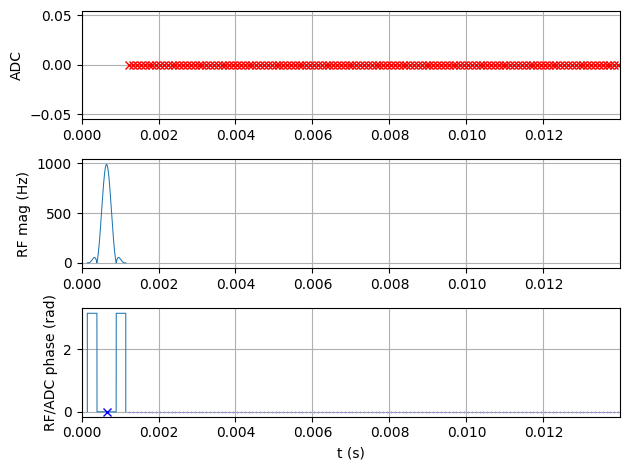

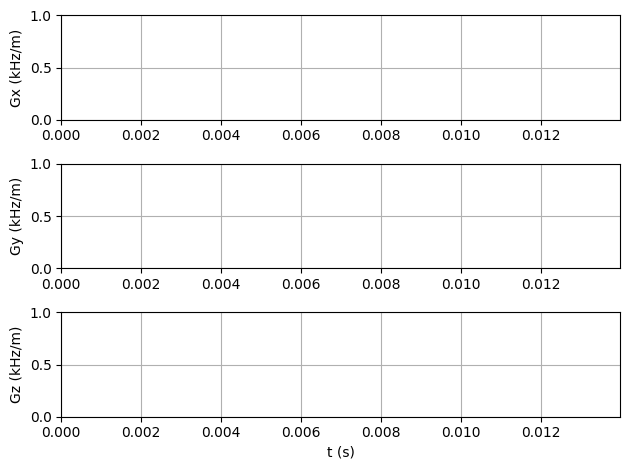

zoom in


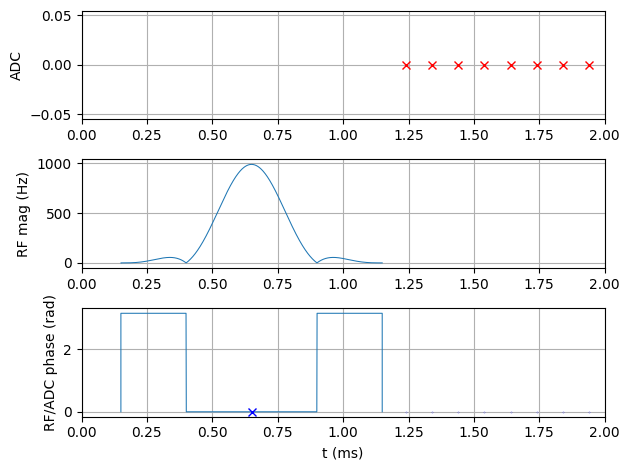

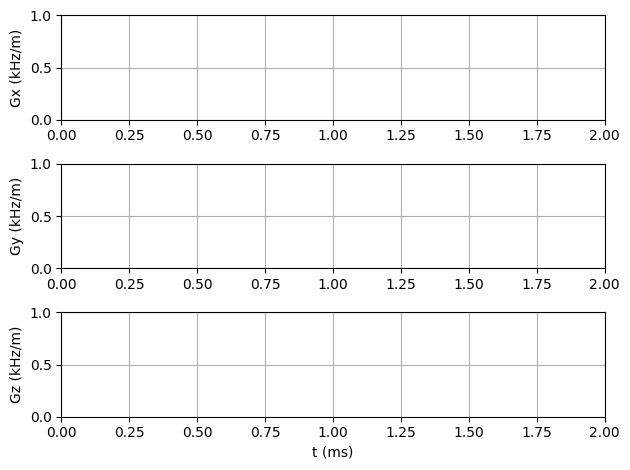

In [22]:
# VISUALIZATION
# plot the entire sequence
seq.plot()


# plot just a small initial part
print('zoom in')
seq.plot(time_range=[0, 0.002], time_disp="ms") #


In [23]:
# WRITE .SEQ
seq_filename='FID.seq'
seq.write(seq_filename)
#from google.colab import files
#files.download(seq_filename)  # Download locally

In [25]:
#@title simulation setup
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
import util
import utils # several helper functions for simulation and recon
#import MRzeroCore as mr0


Calculating repetition 1 / 1 - done


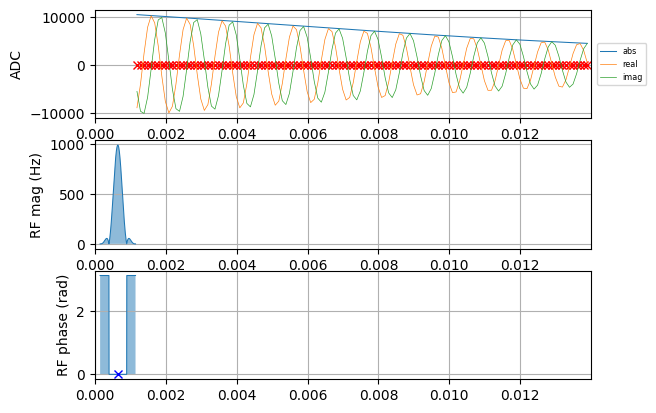

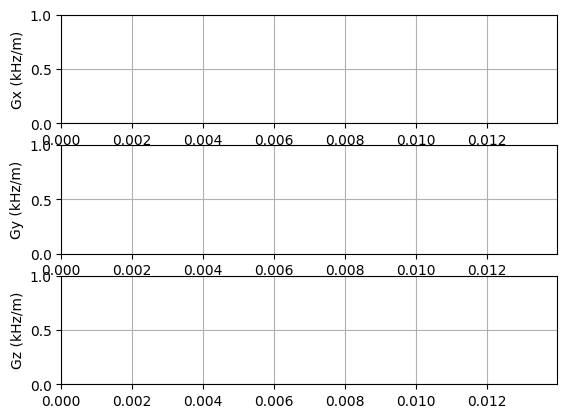

In [29]:
#@title simulation setup
# kscape_adc.shape is [N_coils, N_meas, N_adc]
kspace_adc=utils.simulate_2d(seq, noise_level=0, n_coils=1, dB0=+1000, B0_scale=1, B0_polynomial=None)
sp_adc, t_adc = util.pulseq_plot(seq, clear=False, signal=kspace_adc.squeeze())


VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


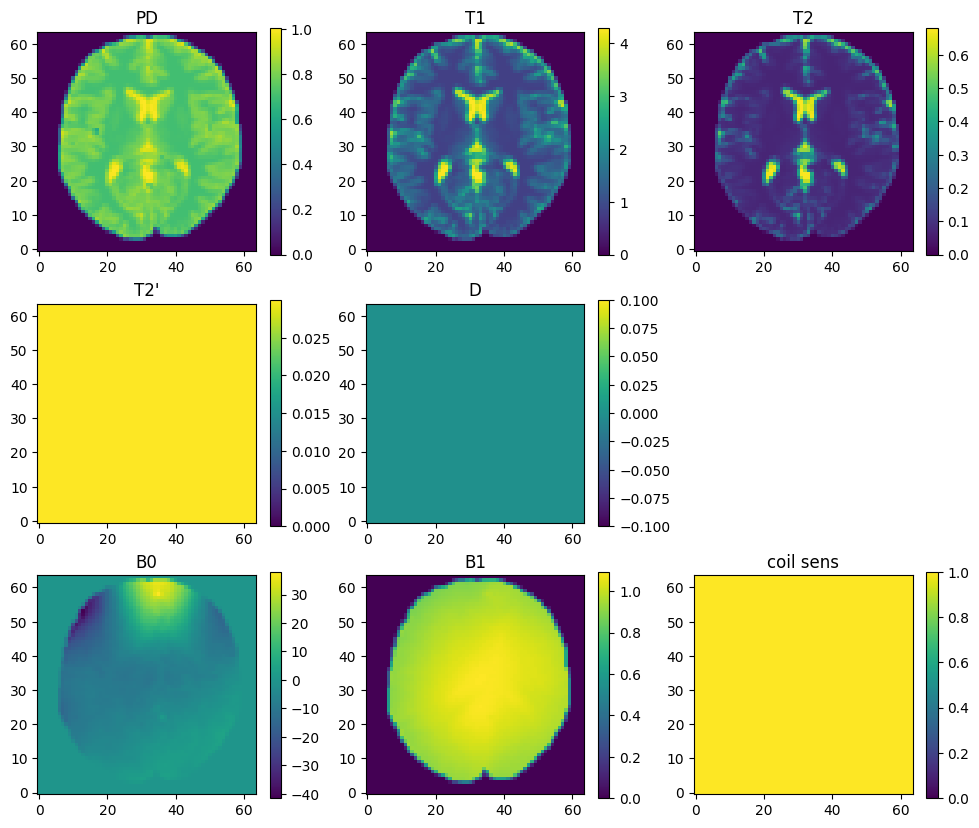

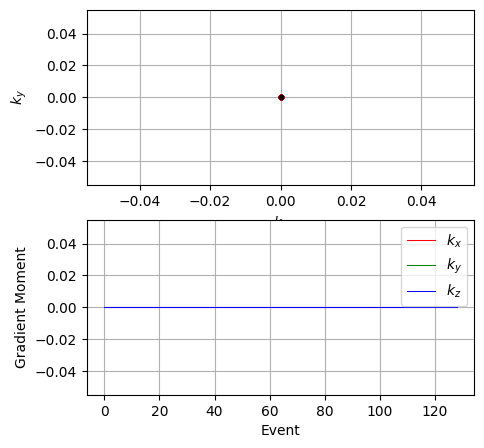

Calculating repetition 1 / 1 - done


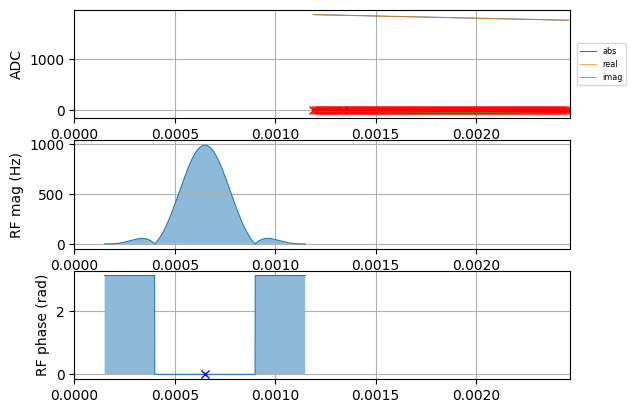

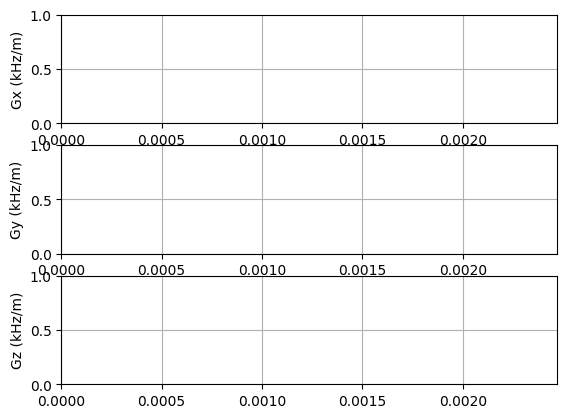

In [10]:
#@title simulation

# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]

# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.T2dash[:] = 30e-3
obj_p.D *= 0
obj_p.B0 *= 1    # alter the B0 inhomogeneity
# Store PD for comparison
PD = obj_p.PD
B0 = obj_p.B0

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq0 = mr0.Sequence.import_file(seq_filename)
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 1000, 1e-5)
signal = mr0.execute_graph(graph, seq0, obj_p)

# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
sp_adc, t_adc = util.pulseq_plot(seq,signal=signal.numpy())